# continuation of energy prediction
Load libraries, read in prepared prediction dataset and continue

1. [Understand Feature Interactions](#Interactions)
    * [buidlings file correlations](#Correlations)
    * [reorder columns, handle skew, scale and polynomial expansion](#FeaturePrep)
2. [Develop | Run Models](#Models)
    * linear regression (simple)
    * linear with train / test
    * decision tree (simple)
    * random forest
    * random forest with cross validation
3. [Evaluate Models](#Evaluation)

In [49]:
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans,DBSCAN
from sklearn.externals.six import StringIO
from sklearn.cross_validation import KFold, cross_val_score

# visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#plt.style.use('default')
plt.style.use('fivethirtyeight')
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

np.set_printoptions(precision=4,suppress=True)

In [50]:
raw_path = os.getcwd()
buildingsPredictFinal = pd.read_csv(raw_path+'buildingsPredictFinal.csv', index_col=0)

<a id='Interactions'></a>
## ** Feature Interactions **
 
<a id='Correlations'></a>
### ** Feature Correlation **

Original buildings corr matrix shape: (12L, 12L)
The correlation matrix for the buildings dataset:


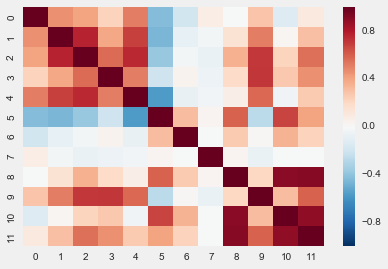

In [51]:
# look briefly at correlations in the new dataset
buildings_corr = buildingsPredictFinal[["Stories","BldgGrade","SqFtTotLiving","Bedrooms",
                            "BathCountFinal","Age","Condition","DegreeDays",
                            "HEATING","BASELOAD","COOLING","TOTAL_COST"]]
buildings_corr_final = np.corrcoef(buildings_corr.T)
print "Original buildings corr matrix shape:",buildings_corr_final.shape
sns.heatmap(buildings_corr_final)
print "The correlation matrix for the buildings dataset:"

### correlation notes
1. we see moderate positive correlation between 2, 3, 5 and 11 (our target "TOTAL_COST")
2. 2, 3, and 5 are "SqFtTotLiving","Bedrooms","Age"
3. "Age" has a strong correlation with "cooling" (the older the building the higher the cooling)
4. "SqFtTotLiving","Bedrooms" are strongly correlated with "BASELOAD"
5. "BldgGrade","Age" are moderately correlated with "BASELOAD"
6. "Age" is moderately anti-correlated with "BASELOAD"
7. "DegreeDays" doesn't seem correlated at all - which is odd

<a id='FeaturePrep'></a>
### ** Feature Preparation **
#### ** Column Ordering by Type **

In [52]:
# create new dataframe that reorders and drops unneeded columns
buildingsColumns = buildingsPredictFinal.columns.tolist()
buildingsColumnsUse = buildingsColumns[0:1]+buildingsColumns[2:6]+buildingsColumns[25:26]+buildingsColumns[1:2]+buildingsColumns[7:8]+buildingsColumns[9:22]+buildingsColumns[35:]
buildingsPredictData = buildingsPredictFinal[buildingsColumnsUse].copy()


#### Set variables to control feature use and observation counts

In [53]:
samplesCount = 20000
buildingColumns = buildingsPredictData.columns.tolist()
buildingTarget = buildingColumns[-1]
buildingFeatures = buildingColumns[0:-1]
buildingFeaturesCat = buildingColumns[8:21]
buildingFeaturesNum = buildingColumns[0:8] 
buildingFeaturesScaleSkew = buildingColumns[0:6]
print "target column is: \n", buildingTarget

print "\nfeature columns are:  \n", buildingFeatures

print "\ncategorical features are:  \n", buildingFeaturesCat

print "\nnumerical features are:  \n", buildingFeaturesNum

print "\nscale-skew features are: \n", buildingFeaturesScaleSkew

target column is: 
TOTAL_COST

feature columns are:  
['Stories', 'SqFtTotLiving', 'Bedrooms', 'BathCountFinal', 'Age', 'DegreeDays', 'BldgGrade', 'Condition', 'HeatSource_1', 'HeatSource_2', 'HeatSource_3', 'HeatSource_4', 'HeatSource_5', 'HeatSource_6', 'HeatSystem_1', 'HeatSystem_2', 'HeatSystem_3', 'HeatSystem_4', 'HeatSystem_5', 'HeatSystem_6', 'HeatSystem_7']

categorical features are:  
['HeatSource_1', 'HeatSource_2', 'HeatSource_3', 'HeatSource_4', 'HeatSource_5', 'HeatSource_6', 'HeatSystem_1', 'HeatSystem_2', 'HeatSystem_3', 'HeatSystem_4', 'HeatSystem_5', 'HeatSystem_6', 'HeatSystem_7']

numerical features are:  
['Stories', 'SqFtTotLiving', 'Bedrooms', 'BathCountFinal', 'Age', 'DegreeDays', 'BldgGrade', 'Condition']

scale-skew features are: 
['Stories', 'SqFtTotLiving', 'Bedrooms', 'BathCountFinal', 'Age', 'DegreeDays']


#### Create "samples" file to work on (dataset too big for my machine)


In [54]:
buildingSamp = buildingsPredictData.head(samplesCount).copy()


In [55]:
buildingSamp.to_csv(raw_path+'buildingSamp.csv')

## Target Summary
#### We can see that 50% of all values fall within a 450 dollar range.

In [56]:
buildingsPredictData[buildingTarget].describe()

count    480685.000000
mean       1499.096554
std         402.228996
min         168.795444
25%        1231.985359
50%        1430.823512
75%        1680.517046
max        9532.973466
Name: TOTAL_COST, dtype: float64

## Categorical Summary
* we may not use any of these columns in our model

In [57]:
# our categoricals are all 0 / 1 values
#  we can see by the means that the columns are very unbalanced

buildingsPredictData[buildingFeaturesCat].describe()

,HeatSource_1,HeatSource_2,HeatSource_3,HeatSource_4,HeatSource_5,HeatSource_6,HeatSystem_1,HeatSystem_2,HeatSystem_3,HeatSystem_4,HeatSystem_5,HeatSystem_6,HeatSystem_7
count,480685.000000,480685.000000,480685.000000,480685.000000,480685.000000,480685.000000,480685.000000,480685.000000,480685.000000,480685.000000,480685.000000,480685.000000,480685.000000
mean,0.160615,0.676391,0.160105,0.000173,0.001073,0.000574,0.033117,0.003208,0.012297,0.075326,0.819154,0.026213,0.029816
std,0.367175,0.467853,0.366704,0.013139,0.032746,0.023955,0.178943,0.056548,0.110208,0.263917,0.384891,0.159767,0.170079
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Numericals summary

In [58]:
# there are no crazy outliers here, but we need to address skew and scale
buildingsPredictData[buildingFeaturesNum].describe()

,Stories,SqFtTotLiving,Bedrooms,BathCountFinal,Age,DegreeDays,BldgGrade,Condition
count,480685.000000,480685.000000,480685.000000,480685.000000,480685.000000,480685.000000,480685.000000,480685.000000
mean,1.431840,2059.900900,3.339561,2.362196,46.902608,5713.677053,7.570769,3.361172
std,0.508471,936.078975,0.926136,0.982832,27.873731,428.372826,1.178647,0.594910
min,1.000000,3.000000,1.000000,1.000000,1.000000,4853.000000,1.000000,1.000000
25%,1.000000,1410.000000,3.000000,2.000000,24.000000,5336.000000,7.000000,3.000000
50%,1.000000,1900.000000,3.000000,2.000000,44.000000,5728.000000,7.000000,3.000000
75%,2.000000,2510.000000,4.000000,3.000000,65.000000,6065.000000,8.000000,4.000000
max,5.000000,48160.000000,58.000000,24.000000,117.000000,6898.000000,20.000000,5.000000


## Fix Skew
* we are going to exclude the "ordered" numericals BldgGrade and Condition since we don't know the distance between values.
* all of the other values are ordered numericals where the distance between values is constant

NOTE: we'll fix skew on the full dataset and then recreate our sample

In [59]:
# evaluate skew
# buildingSkew = stats.skew(buildingsPredictData[buildingFeaturesScaleSkew])
buildingSkews = buildingsPredictData[buildingFeaturesScaleSkew].skew()
skew_cols = buildingSkews[np.abs(buildingSkews)>0.4].index.tolist()
print skew_cols
print buildingSkews

['Stories', 'SqFtTotLiving', 'Bedrooms', 'BathCountFinal', 'Age']
Stories           0.686651
SqFtTotLiving     2.054299
Bedrooms          1.362932
BathCountFinal    0.558046
Age               0.484615
DegreeDays        0.122491
dtype: float64


In [60]:
# fix skew on a copy of the data for merge back in
buildingPredictSkew = buildingsPredictData[skew_cols].copy()
buildingPredictSkew[skew_cols] = np.log(buildingPredictSkew[skew_cols])
buildingPredictSkew.tail()

,Stories,SqFtTotLiving,Bedrooms,BathCountFinal,Age
NEW_KEY,,,,,
703770,0.693147,7.258412,1.098612,0.693147,0.693147
703771,0.693147,7.258412,1.098612,0.693147,0.693147
703772,0.693147,7.258412,1.098612,0.693147,0.693147
704319,0.693147,7.272398,1.098612,1.098612,2.302585
704455,0.000000,7.218910,1.098612,0.000000,4.127134


In [61]:
#merge back in
#buildingsPredictData[skew_cols] = buildingPredictSkew[skew_cols]
#buildingsPredictData.tail()

## Scale the Data

In [62]:
# run Zscoring on select features to adjust scale.
scalex = StandardScaler()

buildingScaledFull = buildingsPredictData.copy()
buildingScaledFull[buildingFeaturesScaleSkew] = scalex.fit_transform(buildingScaledFull[buildingFeaturesScaleSkew])

In [63]:
buildingScaledFull.TOTAL_COST = buildingScaledFull.TOTAL_COST.astype(int)
buildingScaledFull["total_cost_bins"] = pd.cut(buildingScaledFull[buildingTarget],15) #create 15 equally-sized bins

In [64]:
# takes a while so remarked out
# pairplot the entire feature set - visually identify a skewed distribution
#sns.pairplot(buildingSamp[buildingFeaturesScaleSkew[0:3]])

In [65]:
#sns.pairplot(buildingScaled[buildingFeaturesNum[0:7]+['total_cost_bins']]
#             ,hue='total_cost_bins', palette='coolwarm')

In [66]:
# see single column linear regression to our target value
#sns.pairplot(buildingScaled, x_vars=[buildingFeaturesNum[0:3]],
#             y_vars=buildingScaled.TOTAL_COST, size=6, aspect=0.8, kind='reg')

## Polynomial features setup

In [67]:
### get random sample before creating polynomials to preserve order with X on the random sample
buildingScaled = buildingScaledFull.sample(n=samplesCount)

In [68]:
feature_cols_names = buildingScaled[buildingFeaturesNum].columns.tolist()
poly2_interact = PolynomialFeatures(degree=2,interaction_only=True)
#don't want the initial constant term, so only keep columns 1 to the end
interactionsOnly_buildingNumeric = poly2_interact.fit_transform(buildingScaled[feature_cols_names])[:,1:]

# grab the categorical features (one hot encoded)
buildingNumeric_encoded = buildingScaled[buildingFeaturesCat]

# concatenate all input features
buildingPolynomial = np.concatenate((interactionsOnly_buildingNumeric,buildingNumeric_encoded.values),axis=1)

Xp = buildingPolynomial
yp = buildingScaled[buildingTarget]

# instantiate and fit
linp = LinearRegression()
linp.fit(Xp, yp)

# print the coefficients

print linp.intercept_
print linp.coef_

ylinp_pred = linp.predict(Xp)
#print ylin_pred
print metrics.r2_score(yp, ylinp_pred)

print "RMSE for TOTAL_COST:",np.sqrt(metrics.mean_squared_error(yp, ylinp_pred))

1895.84471011
[  49.9476  466.3107  -44.4697 -145.172   168.6154  -19.9491  -22.369
  -45.3524  -18.9835    9.8102  -10.8054  -10.5699    2.6756    3.4903
  -15.1454  -13.8353  -12.0257   88.8911    1.2526   -5.224   -24.5986
   13.7614   15.846    -0.0218   11.8794    2.4557  -15.1725    4.8607
   12.2441   15.8921   16.2886    6.2101   29.6939    4.5071   -2.1122
    2.9068  142.2653  149.7036  147.1042  137.2183  133.8196  108.1616
 -286.0702 -235.9001 -282.7861 -280.2856 -265.0873 -271.0183 -276.0332]
0.827644612133
RMSE for TOTAL_COST: 170.090536419


In [69]:
print buildingPolynomial.shape
print interactionsOnly_buildingNumeric.shape
print buildingScaled.shape

(20000L, 49L)
(20000L, 36L)
(20000, 23)


## setup for models

In [70]:
# for standard (non - polynomial)
feature_cols = buildingScaled[buildingFeaturesNum]
X = feature_cols
y = buildingScaled[buildingTarget]



In [71]:
# output for Alteryx
buildingScaled.to_csv(raw_path+'buildingScaledStillSkewed.csv')

In [72]:
# train / test standard
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# train / test polynomial
Xp_train, Xp_test, yp_train, yp_test = train_test_split(Xp, yp, test_size=0.2)

print "training data size:",X_train.shape
print "testing data size:",X_test.shape
print "training data size - poly:",Xp_train.shape
print "testing data size - poly:",Xp_test.shape

training data size: (16000, 8)
testing data size: (4000, 8)
training data size - poly: (16000L, 49L)
testing data size - poly: (4000L, 49L)


<a id='Models'></a>
## ** Dev / Run Models **
### Linear Regression

In [73]:
# instantiate and fit
lin1 = LinearRegression()
lin1.fit(X, y)

# print the coefficients

print lin1.intercept_
print lin1.coef_

ylin_pred = lin1.predict(X)
#print ylin_pred
metrics.r2_score(y, ylin_pred)

1489.57039968
[  37.9721  273.3341   76.1909   16.3889  300.4551   11.0923   -8.23
   21.5954]


0.77182900238316354

In [74]:
zip(X, lin1.coef_)

[('Stories', 37.972071962282733),
 ('SqFtTotLiving', 273.33409522797854),
 ('Bedrooms', 76.190947632107992),
 ('BathCountFinal', 16.388929033507747),
 ('Age', 300.45510169625123),
 ('DegreeDays', 11.092345943614855),
 ('BldgGrade', -8.2299922578136879),
 ('Condition', 21.595409219814975)]

In [75]:
print "RMSE for TOTAL_COST:",np.sqrt(metrics.mean_squared_error(y, ylin_pred))

RMSE for TOTAL_COST: 195.703205577


### Linear with Train / Test split

In [76]:
#train on training set
lin2= LinearRegression()
lin2.fit(X_train, y_train)
lin2p= LinearRegression()
lin2p.fit(Xp_train, yp_train)

#generate predictions on training set and evaluate
y_pred_train = lin2.predict(X_train)
print "Training set RMSE:",np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
yp_pred_train = lin2p.predict(Xp_train)
print "Training set RMSE - poly:",np.sqrt(metrics.mean_squared_error(yp_train, yp_pred_train))

#generate predictions on test set and evaluate
y_pred_test = lin2.predict(X_test)
print "Test set RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
yp_pred_test = lin2p.predict(Xp_test)
print "Test set RMSE - poly:",np.sqrt(metrics.mean_squared_error(yp_test, yp_pred_test))

print "Test set R2:",metrics.r2_score(y_test, y_pred_test)
print "Test set R2 - poly:",metrics.r2_score(yp_test, yp_pred_test)

Training set RMSE: 194.942173393
Training set RMSE - poly: 163.269724916
Test set RMSE: 198.762017049
Test set RMSE - poly: 195.715846363
Test set R2: 0.790314589594
Test set R2 - poly: 0.780528698135


### There is non-linearity in the data.  Polynomial features return better results

### Decision Tree

In [77]:
decision_tree = DecisionTreeRegressor(max_depth=6)
decision_tree.fit(X_train,y_train)
y_test_predict = decision_tree.predict(X_test)
print "Decision Tree RMSE:",np.sqrt(
    mean_squared_error(y_test,
                       y_test_predict))

decision_treep = DecisionTreeRegressor(max_depth=6)
decision_treep.fit(Xp_train,yp_train)
yp_test_predict = decision_treep.predict(Xp_test)
print "Decision Tree RMSE - poly:",np.sqrt(
    mean_squared_error(yp_test,
                       yp_test_predict))

Decision Tree RMSE: 150.084836206
Decision Tree RMSE - poly: 189.938891442


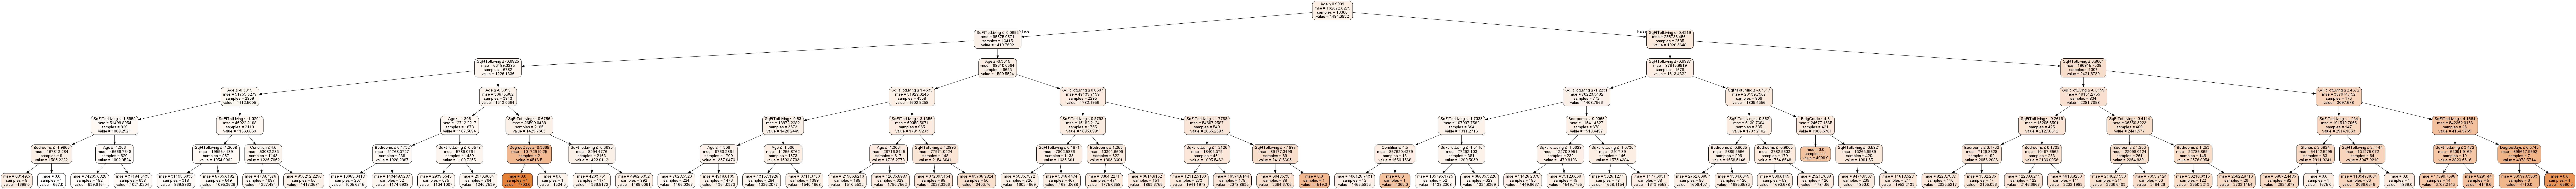

In [78]:
# tree for standard
dot_data = StringIO()  
export_graphviz(decision_tree, out_file=dot_data,  
                    feature_names=X_train.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

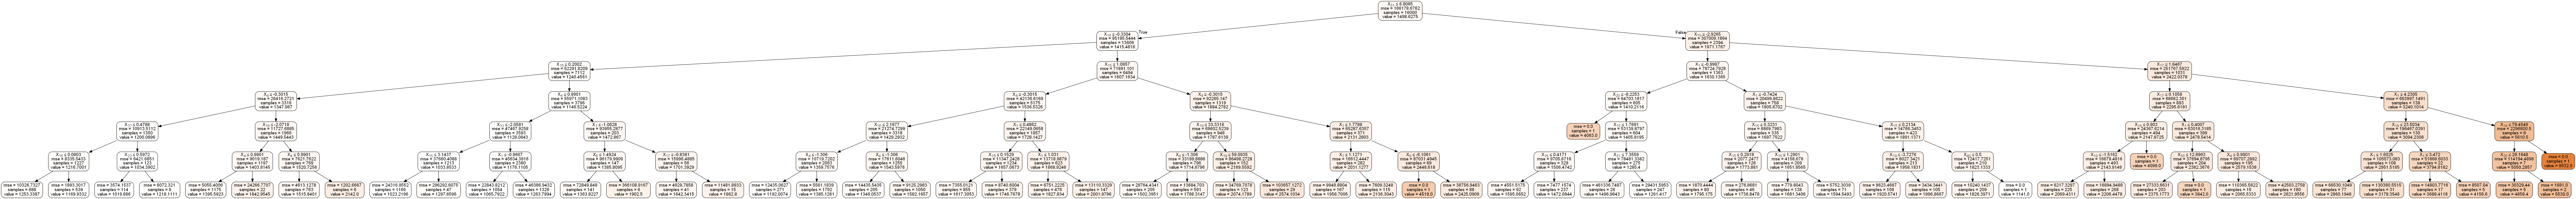

In [79]:
# tree for polynomial
## I have no idea how to label the columns...
dot_data = StringIO()  
export_graphviz(decision_treep, out_file=dot_data,  
                    #feature_names=buildingFeatures,  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

Decision Tree Train/Test RMSE: 355.502707486   383.590621973
Decision Tree Train/Test RMSE: 268.415965812   298.414739917
Decision Tree Train/Test RMSE: 225.007818766   252.306026482
Decision Tree Train/Test RMSE: 177.678510217   198.84037853
Decision Tree Train/Test RMSE: 151.271420401   171.56510514
Decision Tree Train/Test RMSE: 127.992218403   161.555804783
Decision Tree Train/Test RMSE: 114.859402491   140.0899976
Decision Tree Train/Test RMSE: 97.2729447539   156.002384039
Decision Tree Train/Test RMSE: 80.0857351092   160.254191327
Decision Tree Train/Test RMSE: 57.1234744587   166.823538669
Decision Tree Train/Test RMSE: 45.3936265562   191.008934657
Decision Tree Train/Test RMSE: 33.92481444   169.608324409
Decision Tree Train/Test RMSE: 25.4972556059   172.114837443
Decision Tree Train/Test RMSE: 18.1417293317   174.693014535
Decision Tree Train/Test RMSE: 8.64957209758   172.263188073
Decision Tree Train/Test RMSE: 4.5769300289   174.899305982
Decision Tree Train/Test RMSE: 

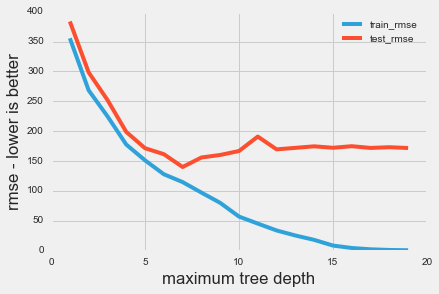

In [80]:
# test for optimal tree depth - STANDARD. 
# data suggest 7 - 10
depths = range(1,20)
train_rmse, test_rmse = [],[]
for depth in depths:
    decision_tree = DecisionTreeRegressor(max_depth=depth,random_state=1)
    decision_tree.fit(X_train,y_train)
    curr_train_rmse = np.sqrt(mean_squared_error(y_train,decision_tree.predict(X_train)))
    curr_test_rmse = np.sqrt(mean_squared_error(y_test,decision_tree.predict(X_test)))
    print "Decision Tree Train/Test RMSE:",curr_train_rmse," ",curr_test_rmse
    train_rmse.append(curr_train_rmse)
    test_rmse.append(curr_test_rmse)
plt.plot(depths,train_rmse,label='train_rmse')
plt.plot(depths,test_rmse,label='test_rmse')
plt.xlabel("maximum tree depth")
plt.ylabel("rmse - lower is better")
plt.legend()

In [81]:
best_single_tree = DecisionTreeRegressor(max_depth=9)
best_single_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [82]:
# feature importance
pd.DataFrame({'feature':feature_cols_names, 'importance':best_single_tree.feature_importances_})

,feature,importance
0,Stories,0.001468
1,SqFtTotLiving,0.610974
2,Bedrooms,0.013846
3,BathCountFinal,0.008853
4,Age,0.334215
5,DegreeDays,0.017765
6,BldgGrade,0.007606
7,Condition,0.005273


Decision Tree Train/Test RMSE: 356.213644563   363.642619221
Decision Tree Train/Test RMSE: 274.503474489   287.59823279
Decision Tree Train/Test RMSE: 230.142451609   254.442701107
Decision Tree Train/Test RMSE: 185.587007893   218.590966619
Decision Tree Train/Test RMSE: 155.893594983   198.254316606
Decision Tree Train/Test RMSE: 133.254722662   184.915768614
Decision Tree Train/Test RMSE: 114.658515588   186.220330046
Decision Tree Train/Test RMSE: 99.7084438106   174.967092846
Decision Tree Train/Test RMSE: 87.4616227428   186.787004277
Decision Tree Train/Test RMSE: 60.4837650204   167.200662518
Decision Tree Train/Test RMSE: 50.1168573516   167.075557583
Decision Tree Train/Test RMSE: 39.0880517387   170.030944445
Decision Tree Train/Test RMSE: 31.0368623331   181.376003621
Decision Tree Train/Test RMSE: 26.0115437311   173.23546343
Decision Tree Train/Test RMSE: 22.6236256608   174.757671874
Decision Tree Train/Test RMSE: 17.2728375983   175.783229229
Decision Tree Train/Test R

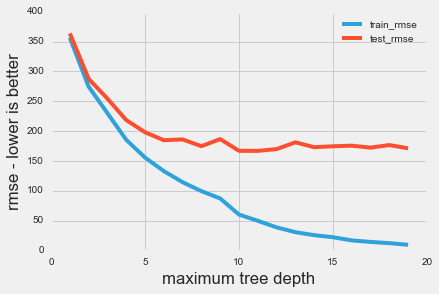

In [83]:
# test for optimal tree depth - POLYNOMIAL. 
# data suggest 8 - 11
depths = range(1,20)
train_rmsep, test_rmsep = [],[]
for depth in depths:
    decision_treep = DecisionTreeRegressor(max_depth=depth,random_state=1)
    decision_treep.fit(Xp_train,yp_train)
    curr_train_rmsep = np.sqrt(mean_squared_error(yp_train,decision_treep.predict(Xp_train)))
    curr_test_rmsep = np.sqrt(mean_squared_error(yp_test,decision_treep.predict(Xp_test)))
    print "Decision Tree Train/Test RMSE:",curr_train_rmsep," ",curr_test_rmsep
    train_rmsep.append(curr_train_rmsep)
    test_rmsep.append(curr_test_rmsep)
plt.plot(depths,train_rmsep,label='train_rmse')
plt.plot(depths,test_rmsep,label='test_rmse')
plt.xlabel("maximum tree depth")
plt.ylabel("rmse - lower is better")
plt.legend()

In [84]:
best_single_treep = DecisionTreeRegressor(max_depth=9)
best_single_treep.fit(Xp_train, yp_train)

DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [85]:
poly_cols_names = Xp.dtype.names

In [86]:
# feature importance - for polynomials the results would need to be converted back
# pd.DataFrame({'feature':poly_cols_names, 'importance':best_single_treep.feature_importances_})

### Random Forest

In [87]:
rf = RandomForestRegressor(n_estimators=200,
                            bootstrap=True,
                            max_features=6,
                            oob_score=True,
                            max_depth=9)

rf.fit(X_train,y_train)
y_pref_rf = rf.predict(X_test)
preds = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,preds))
print "RMSE on test set:",rmse

RMSE on test set: 134.472604405


In [88]:
pd.DataFrame({'feature':feature_cols_names, 'importance':rf.feature_importances_}).sort_values(by='importance',ascending=False)

,feature,importance
1,SqFtTotLiving,0.498977
4,Age,0.379165
2,Bedrooms,0.048760
3,BathCountFinal,0.029078
6,BldgGrade,0.019740
5,DegreeDays,0.011162
7,Condition,0.008191
0,Stories,0.004927


### DegreeDays not very important

In [89]:
rfp = RandomForestRegressor(n_estimators=200,
                            bootstrap=True,
                            max_features=6,
                            oob_score=True,
                            max_depth=9)

rfp.fit(Xp_train,yp_train)
yp_pref_rfp = rfp.predict(Xp_test)
predsp = rfp.predict(Xp_test)
rmsep = np.sqrt(mean_squared_error(yp_test,predsp))
print "RMSE on test set - poly:",rmsep

RMSE on test set - poly: 153.971918296


In [90]:
#estimators = range(200, 500, 50)
features = range(1,10)
RMSE_scores = []

for feature in features:
    rfb = RandomForestRegressor(n_estimators=50,
                               bootstrap=True,
                               oob_score=True,
                               max_features=feature,
                               max_depth=10)
    rfb.fit(Xp_train,yp_train)
    yp_pref_rfb = rfb.predict(Xp_test)
    predsp = rfb.predict(Xp_test)
    rmsep = np.sqrt(mean_squared_error(yp_test,predsp))
    RMSE_scores.append(rmsep)



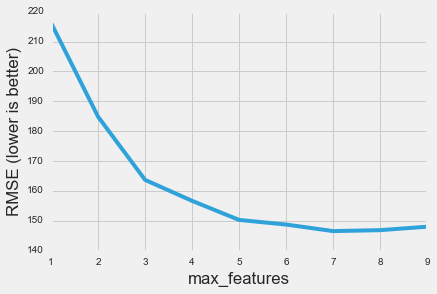

In [91]:
# plot n_estimators (x-axis) versus RMSE (y-axis)
plt.plot(features, RMSE_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE (lower is better)')

In [92]:
pd.DataFrame({'feature':poly_cols_names, 'importance':rfp.feature_importances_}).sort_values(by='importance',ascending=False)

,feature,importance
4,None,1.025738e-01
31,None,9.629309e-02
19,None,8.515047e-02
20,None,8.453291e-02
32,None,8.352541e-02
1,None,7.905132e-02
17,None,6.341377e-02
25,None,3.998994e-02
15,None,3.930131e-02
22,None,3.649649e-02


### Cross Validation - random forest

In [93]:
# STANDARD - RMSE
cross_val_scores = cross_val_score(rf,X,y,cv=10, scoring='mean_squared_error')
print "10-fold mse's:\n",cross_val_scores,"\n"

print "Mean cv-mse:",np.mean(cross_val_scores),"\n"

print "10-fold rmse's:\n",np.sqrt(np.abs(cross_val_scores)),"\n"

print "Mean cv-rmse:\n",np.sqrt(np.abs(cross_val_scores)).mean()

10-fold mse's:
[-11596.3408 -13539.6249 -10015.8796 -13659.6501 -12180.4993 -11580.0519
 -32615.6801 -30938.161  -25747.4711  -5980.3454] 

Mean cv-mse: -16785.3703989 

10-fold rmse's:
[ 107.6863  116.3599  100.0794  116.8745  110.3653  107.6106  180.5981
  175.8925  160.4602   77.3327] 

Mean cv-rmse:
125.325948753


In [94]:
# POLYNOMIAL - RMSE
cross_val_scoresp = cross_val_score(rfp,Xp,yp,cv=10, scoring='mean_squared_error')
print "10-fold mse's:\n",cross_val_scores,"\n"

print "Mean cv-mse:",np.mean(cross_val_scoresp),"\n"

print "10-fold rmse's:\n",np.sqrt(np.abs(cross_val_scoresp)),"\n"

print "Mean cv-rmse:\n",np.sqrt(np.abs(cross_val_scoresp)).mean()

10-fold mse's:
[-11596.3408 -13539.6249 -10015.8796 -13659.6501 -12180.4993 -11580.0519
 -32615.6801 -30938.161  -25747.4711  -5980.3454] 

Mean cv-mse: -18180.1777361 

10-fold rmse's:
[ 108.3209  112.7821  108.3796  121.1261  116.5426  111.6516  183.566
  187.3997  171.5947   81.3804] 

Mean cv-rmse:
130.274366177


<a id='Evaluation'></a>
## Evaluate Models

** I wasn't able to complete: **
* cross validation with other models
* setting up CV-grid
* setting up the model evaluation AUC / ROC models from last class

** I found the following that I was surprised about: **
* skewed vs unskewed data didn't make as much difference as I'd expect (the data is fairly skewed)
* polynomical expansion:
    * improved linear regression alot (not unexpected)
    * had little impact on random forest (??)
* linear model (train | test) with polynomial expansion performs really well...about as well as Cross Validated Random Forest with / without polynomial expansion
* random forest with polynomial expansion still optimizes (best I can tell) only ~6 features.  Same if not slightly less than the non expanded set.
* DegreeDays has basically no impact on the model (??) Felt this was very strange given its a climate indicator and heating and cooling cost (everything else being equal) should tavel with this number

** Best Model ** 
When I used 60k random samples (takes a while to run) but with the same settings in the models here, I found:
* Linear Regression w/ Polynomials Test | Train --> RMSE ~ 110
* Single Decision Trees Test | train --> RMSE as low as 115
* Random Forest Cross Validated w/ Polynomials was in between and without performed slightly worse

#### overall, that means we could get within ~110 USD on average of the actual energy costs - not bad!
* costs should be a mix of these 5 things
    * home size (sqft, beds, etc)
    * home construction quality | materials details (style, year of construction / remodel as proxy)
    * climate (DegreeDays should be a proxy for this)
    * consumption pattern (what do you set your thermostat for?) (out of scope)
    * energy costs per unit (out of scope)
    
Given the number of items out of scope, I think the estimatation here is "decent" but not great.
  

** Best Model ALTERYX **
The alteryx models all outperformed the Sklearn models.  I'm sure it has to do with settings, but not sure where. 

For skewed data:
* Random Forest as low as --> RMSE 24
* Booted Model as low as --> RMSE 45

For unskewed data: RMSE results are on average 10% **worse**

NOTE: I didn't look into how to import the polynomials to Alteryx.  However some of their models let you specify the level of "interactions" which I defined as 2 and believe is the same thing.